# Phishing SMS : CoPhi @ SJTU
**Author**: Napassorn LITCHIOWONG (Pleng/林艺文)
pleng@u.nus.edu

Set checkpoint and run evaluate script

Total runs: 10
Baselines: 2
Saved: /content/drive/MyDrive/sms-baselines/experiments/aggregated_summary_by_baseline.csv


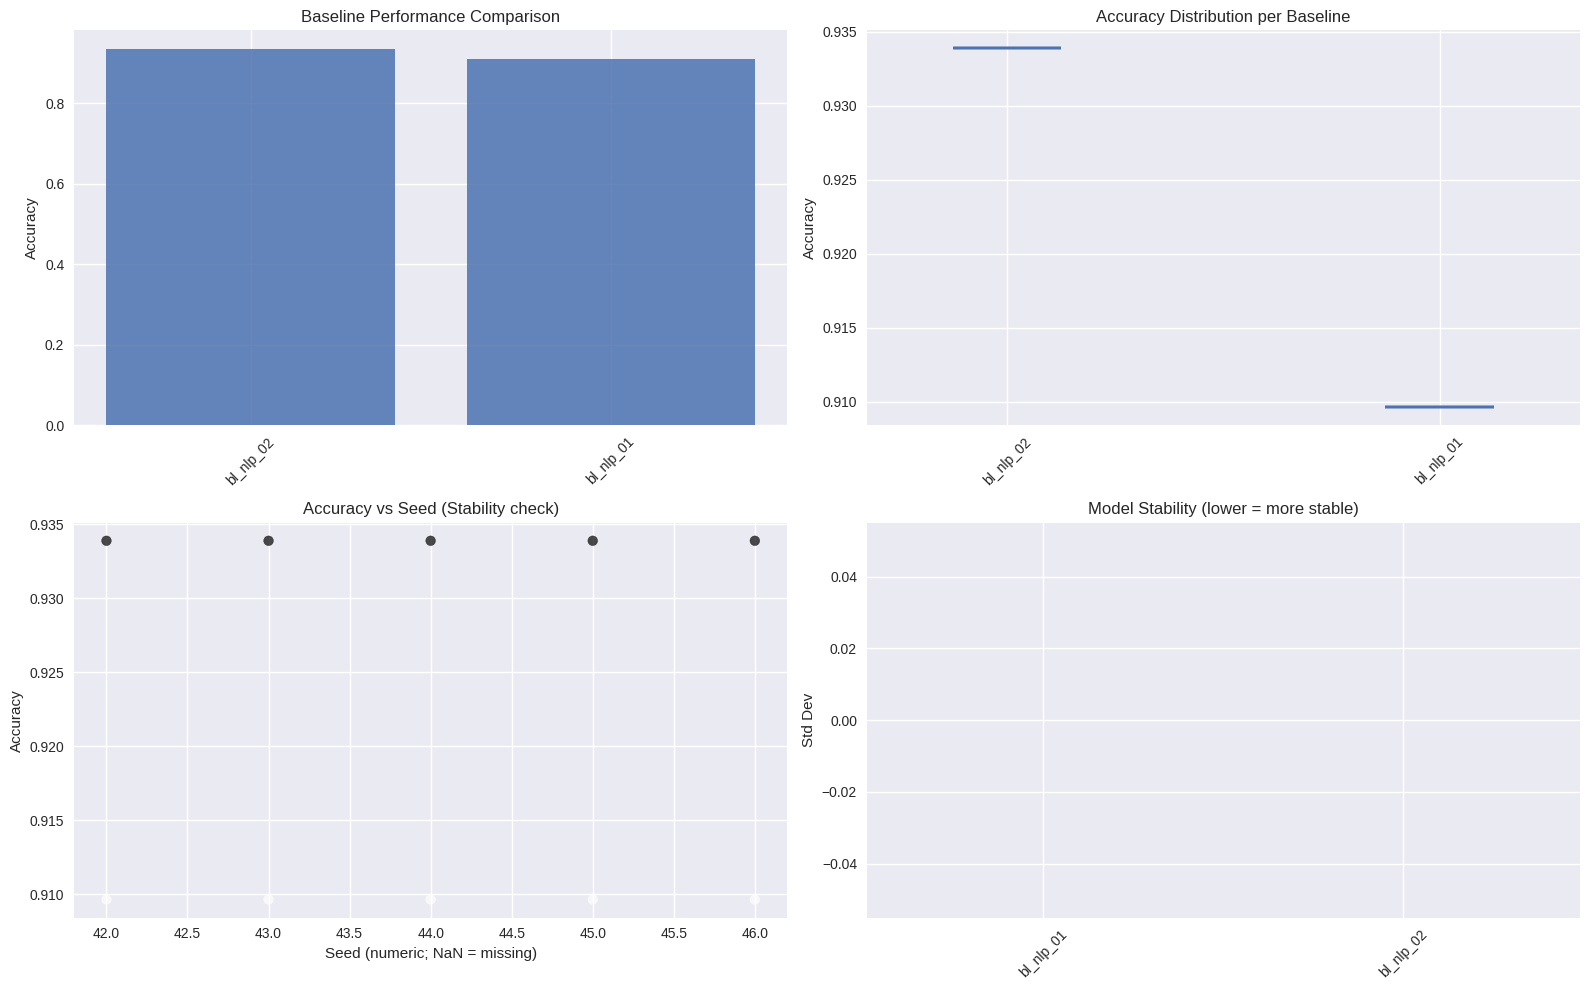

Saved: /content/drive/MyDrive/sms-baselines/experiments/comprehensive_baseline_analysis.png
Saved: /content/drive/MyDrive/sms-baselines/experiments/metrics_summary_table.csv
 baseline  accuracy_count  accuracy_mean  accuracy_std  precision_macro_mean  recall_macro_mean  f1_macro_mean
bl_nlp_01               5         0.9096        0.0000                0.9065             0.6685         0.7406
bl_nlp_02               5         0.9339        0.0000                0.9251             0.7669         0.8299


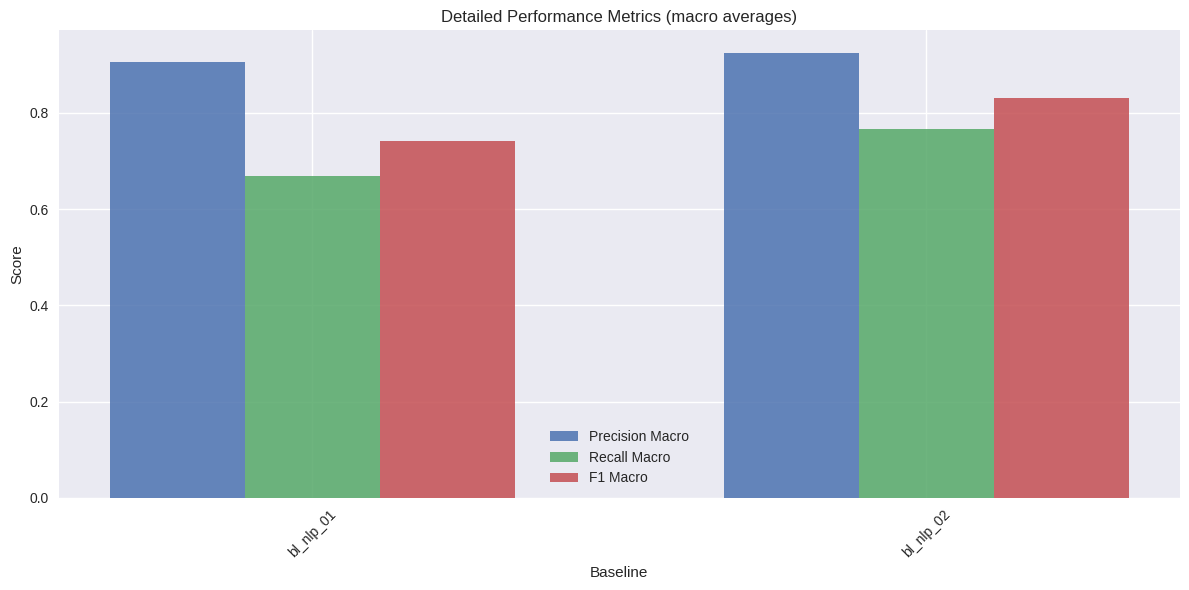

Saved: /content/drive/MyDrive/sms-baselines/experiments/detailed_metrics_comparison.png


/tmp/ipython-input-1263923398.py:256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


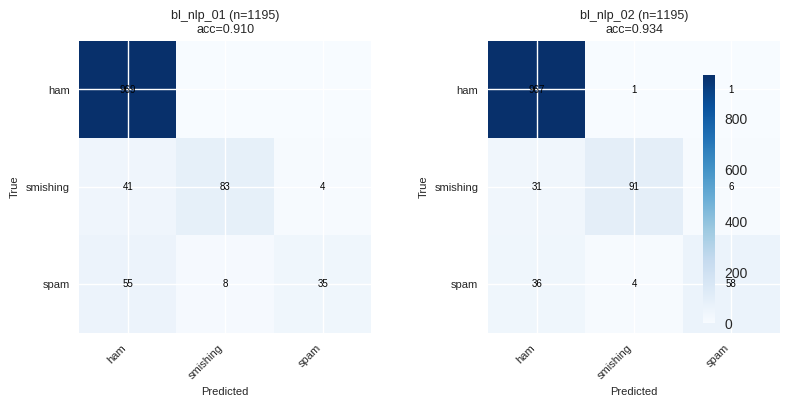

Saved: /content/drive/MyDrive/sms-baselines/experiments/confusion_matrices_all_baselines.png
Saved: /content/drive/MyDrive/sms-baselines/experiments/experiment_summary.json
DONE


In [ ]:
import os, json, math
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime, re
from pathlib import Path

REPO_DIR = "/content/drive/MyDrive/sms-baselines"
EXP_DIR = os.path.join(REPO_DIR, "experiments")
os.makedirs(EXP_DIR, exist_ok=True)

plt.style.use('seaborn-v0_8')

def collect_all_runs():
    runs = []
    for base in sorted(os.listdir(EXP_DIR)):
        base_dir = os.path.join(EXP_DIR, base)
        if not os.path.isdir(base_dir):
            continue
        summary_csv = os.path.join(base_dir, "summary.csv")
        if os.path.exists(summary_csv):
            try:
                df = pd.read_csv(summary_csv)
                for _, row in df.iterrows():
                    runs.append({
                        "baseline": base,
                        "run_id": row.get("run_id"),
                        "seed": row.get("seed"),
                        "accuracy": row.get("accuracy"),
                        "outdir": row.get("outdir")
                    })
            except Exception:
                continue
        else:
            for sub in sorted(os.listdir(base_dir)):
                run_dir = os.path.join(base_dir, sub)
                if not os.path.isdir(run_dir):
                    continue
                meta_path = os.path.join(run_dir, "run_meta.json")
                results_path = os.path.join(run_dir, "results.json")
                acc = None
                if os.path.exists(results_path):
                    try:
                        res = json.load(open(results_path))
                        acc = res.get("accuracy")
                    except Exception:
                        pass
                if os.path.exists(meta_path):
                    try:
                        m = json.load(open(meta_path))
                        run_id = m.get("run_id") or sub
                        seed = m.get("seed")
                    except Exception:
                        run_id = sub
                        seed = None
                else:
                    run_id = sub
                    seed = None
                runs.append({
                    "baseline": base,
                    "run_id": run_id,
                    "seed": seed,
                    "accuracy": acc,
                    "outdir": run_dir
                })
    return runs

runs = collect_all_runs()
if not runs:
    raise FileNotFoundError("No experiment runs found under EXP_DIR")

df_runs = pd.DataFrame(runs)
df_runs = df_runs.dropna(subset=['accuracy'])

if 'seed' in df_runs.columns:
    df_runs['seed_numeric'] = pd.to_numeric(df_runs['seed'], errors='coerce')
else:
    df_runs['seed_numeric'] = np.nan

print("Total runs:", len(df_runs))
print("Baselines:", df_runs['baseline'].nunique())

agg_stats = df_runs.groupby("baseline")["accuracy"].agg(["count", "mean", "std", "min", "max"]).reset_index()
agg_stats = agg_stats.rename(columns={"mean":"accuracy_mean","std":"accuracy_std"})
agg_stats["accuracy_std"] = agg_stats["accuracy_std"].fillna(0)
agg_stats = agg_stats.sort_values("accuracy_mean", ascending=False).reset_index(drop=True)
agg_stats.to_csv(os.path.join(EXP_DIR, "aggregated_summary_by_baseline.csv"), index=False)
print("Saved:", os.path.join(EXP_DIR, "aggregated_summary_by_baseline.csv"))

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].bar(agg_stats["baseline"], agg_stats["accuracy_mean"],
              yerr=agg_stats["accuracy_std"], capsize=6, alpha=0.85)
axes[0,0].set_ylabel("Accuracy")
axes[0,0].set_title("Baseline Performance Comparison")
axes[0,0].tick_params(axis='x', rotation=45)

violin_data = [df_runs[df_runs['baseline']==b]['accuracy'].values for b in agg_stats['baseline']]
axes[0,1].violinplot(violin_data, positions=range(len(agg_stats)), showmeans=True)
axes[0,1].set_xticks(range(len(agg_stats)))
axes[0,1].set_xticklabels(agg_stats['baseline'], rotation=45)
axes[0,1].set_ylabel("Accuracy")
axes[0,1].set_title("Accuracy Distribution per Baseline")

axes[1,0].scatter(df_runs['seed_numeric'], df_runs['accuracy'],
                  c=[(hash(b) % 256)/255. for b in df_runs['baseline']], alpha=0.7)
axes[1,0].set_xlabel("Seed (numeric; NaN = missing)")
axes[1,0].set_ylabel("Accuracy")
axes[1,0].set_title("Accuracy vs Seed (Stability check)")

var_by_baseline = df_runs.groupby('baseline')['accuracy'].std().fillna(0)
axes[1,1].bar(var_by_baseline.index, var_by_baseline.values, alpha=0.85)
axes[1,1].set_ylabel("Std Dev")
axes[1,1].set_title("Model Stability (lower = more stable)")
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
agg_fig_path = os.path.join(EXP_DIR, "comprehensive_baseline_analysis.png")
plt.savefig(agg_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved:", agg_fig_path)

def extract_detailed_metrics(run_dir):
    results_path = os.path.join(run_dir, "results.json")
    if not os.path.exists(results_path):
        return {}
    try:
        with open(results_path) as f:
            res = json.load(f)
        cr = res.get("classification_report", {})
        if isinstance(cr, dict):
            macro = cr.get("macro avg", cr.get("macro_avg", {}))
            weighted = cr.get("weighted avg", cr.get("weighted_avg", {}))
            return {
                "precision_macro": macro.get("precision"),
                "recall_macro": macro.get("recall"),
                "f1_macro": macro.get("f1-score", macro.get("f1")),
                "precision_weighted": weighted.get("precision"),
                "recall_weighted": weighted.get("recall"),
                "f1_weighted": weighted.get("f1-score", weighted.get("f1"))
            }
    except Exception:
        pass
    return {}

detailed_rows = []
for _, r in df_runs.iterrows():
    metrics = extract_detailed_metrics(r['outdir'])
    detailed_rows.append({**r.to_dict(), **metrics})
df_detailed = pd.DataFrame(detailed_rows)

grouped = df_detailed.groupby('baseline').agg({
    'accuracy': ['count','mean','std'],
    'precision_macro':'mean','recall_macro':'mean','f1_macro':'mean'
}).fillna(0)
grouped.columns = ['_'.join(filter(None, map(str,c))).strip('_') for c in grouped.columns.values]
grouped = grouped.reset_index()
metrics_summary_csv = os.path.join(EXP_DIR, "metrics_summary_table.csv")
grouped.to_csv(metrics_summary_csv, index=False)
print("Saved:", metrics_summary_csv)
print(grouped.to_string(index=False, float_format='%.4f'))

metrics_cols = [c for c in ["precision_macro","recall_macro","f1_macro"] if c in df_detailed.columns and df_detailed[c].notna().any()]
if metrics_cols:
    fig, ax = plt.subplots(figsize=(12, 6))
    metric_means = df_detailed.groupby("baseline")[metrics_cols].mean()
    metric_stds = df_detailed.groupby("baseline")[metrics_cols].std().fillna(0)
    x = np.arange(len(metric_means))
    width = 0.22
    for i, metric in enumerate(metrics_cols):
        ax.bar(x + i*width, metric_means[metric], width, yerr=metric_stds[metric], capsize=4, label=metric.replace('_',' ').title(), alpha=0.85)
    ax.set_xticks(x + width)
    ax.set_xticklabels(metric_means.index, rotation=45)
    ax.set_xlabel("Baseline")
    ax.set_ylabel("Score")
    ax.set_title("Detailed Performance Metrics (macro averages)")
    ax.legend()
    plt.tight_layout()
    metrics_fig_path = os.path.join(EXP_DIR, "detailed_metrics_comparison.png")
    plt.savefig(metrics_fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved:", metrics_fig_path)
else:
    print("No macro metrics found in any results.json; skipping detailed metrics plot.")

best_per_baseline = df_runs.sort_values('accuracy', ascending=False).groupby('baseline', as_index=False).first()

cms = []
labels_set = set()
rows_info = []
for _, br in best_per_baseline.iterrows():
    outdir = br['outdir']
    det_csv = os.path.join(outdir, "results_detailed.csv")
    if not os.path.exists(det_csv):
        print(f"Skipping {br['baseline']}: no results_detailed.csv")
        continue
    try:
        df_det = pd.read_csv(det_csv)
    except Exception as e:
        print(f"Skipping {br['baseline']}: read error: {e}")
        continue
    if ('true_label' not in df_det.columns) or ('pred_label' not in df_det.columns):
        print(f"Skipping {br['baseline']}: missing true_label or pred_label")
        continue
    cm = pd.crosstab(df_det['true_label'], df_det['pred_label'])
    labels_set.update(cm.index.tolist())
    labels_set.update(cm.columns.tolist())
    sample_count = len(df_det)
    acc_val = br['accuracy'] if not pd.isna(br['accuracy']) else None
    cms.append({'baseline': br['baseline'], 'cm': cm, 'n': sample_count, 'accuracy': acc_val})

if not cms:
    print("No confusion matrices available (no valid results_detailed.csv files).")
else:
    all_labels = sorted(labels_set)
    aligned = []
    vmax = 0
    for item in cms:
        cm = item['cm']
        cm_al = pd.DataFrame(0, index=all_labels, columns=all_labels)
        for r in cm.index:
            for c in cm.columns:
                cm_al.at[r, c] = cm.at[r, c]
        aligned.append({'baseline': item['baseline'], 'cm': cm_al, 'n': item['n'], 'accuracy': item['accuracy']})
        vmax = max(vmax, cm_al.values.max())

    n = len(aligned)
    cols = min(3, n)    # change this to 4 if you want more columns per row
    rows = math.ceil(n / cols)
    fig_w = max(4 * cols, 6)
    fig_h = max(3.5 * rows, 4)
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)
    for ax in axes.ravel():
        ax.axis('off')

    for i, item in enumerate(aligned):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.axis('on')
        im = ax.imshow(item['cm'].values, interpolation='nearest', cmap='Blues', vmin=0, vmax=vmax)
        title = f"{item['baseline']} (n={item['n']})"
        if item['accuracy'] is not None:
            title += f"\nacc={item['accuracy']:.3f}"
        ax.set_title(title, fontsize=9)
        ax.set_xticks(np.arange(len(all_labels)))
        ax.set_yticks(np.arange(len(all_labels)))
        ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(all_labels, fontsize=8)
        for rr in range(item['cm'].shape[0]):
            for cc in range(item['cm'].shape[1]):
                val = int(item['cm'].iat[rr, cc])
                if val > 0:
                    ax.text(cc, rr, str(val), ha='center', va='center', color='black', fontsize=7)
        ax.set_xlabel("Predicted", fontsize=8)
        ax.set_ylabel("True", fontsize=8)

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, hspace=0.4, wspace=0.4)
    cm_all_path = os.path.join(EXP_DIR, "confusion_matrices_all_baselines.png")
    plt.savefig(cm_all_path, dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved:", cm_all_path)

summary_stats = {
    "experiment_date": datetime.datetime.now().isoformat(),
    "total_runs": int(len(df_runs)),
    "total_baselines": int(df_runs['baseline'].nunique()),
    "baseline_rankings": agg_stats[['baseline','accuracy_mean','accuracy_std']].to_dict('records')
}
with open(os.path.join(EXP_DIR, "experiment_summary.json"), "w") as f:
    json.dump(summary_stats, f, indent=2)
print("Saved:", os.path.join(EXP_DIR, "experiment_summary.json"))
print("DONE")
